In [1]:
import gc

In [4]:
gc.collect()

15

In [1]:
from py2neo.data import Node, Relationship
import py2neo

In [2]:
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "graphsagE@4"))

In [3]:
import pandas as pd
import os

import stellargraph as sg
from stellargraph.connector.neo4j import Neo4jGraphSAGENodeGenerator, Neo4jStellarGraph
from stellargraph.layer import GraphSAGE, AttentionalAggregator

import numpy as np
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

import time
%matplotlib inline

In [4]:
# Authors
authors_df = graph.run(
    """
    MATCH (n:Author) RETURN n.name as name
    """).to_data_frame()

In [5]:
(authors_df.drop_duplicates() == authors_df).drop_duplicates()

,name
0,True


In [6]:
len(authors_df)

527402

In [7]:
authors_df.head()

,name
0,Sanjiban Sekhar Roy
1,V. Madhu Viswanatham
2,N. Saraf
3,Anant Gupta
4,Daniel Wolff


In [8]:
# To give all the authors a identifier
dic_authors = {}
for i in range(len(authors_df)):
    dic_authors[authors_df['name'][i]] = i

In [9]:
len(dic_authors)

527402

In [10]:
authors_ = list(dic_authors.keys())
dic_authors[authors_[50]]

50

In [11]:
co = graph.run(
    """
    MATCH p=(a)-[r:CO_AUTHOR_DIRECT]->(b) RETURN a.name as source,b.name as target 
    """).to_data_frame()

In [12]:
print(co.shape)
co.head()

(1430992, 2)


,source,target
0,Sanjiban Sekhar Roy,V. Madhu Viswanatham
1,Sanjiban Sekhar Roy,Dev Gaurav
2,Sanjiban Sekhar Roy,P. Venkata Krishna
3,Sanjiban Sekhar Roy,N. Saraf
4,Sanjiban Sekhar Roy,Dishant Mittal


In [13]:
co[co['source'] == 'Roel Peeters']

,source,target
996920,Roel Peeters,Christian Wachsmann
996921,Roel Peeters,Bart Mennink


In [14]:
cal_colab_direct_df = graph.run(
    """
    MATCH p=(a)-[r:CO_AUTHOR_DIRECT]->(b) RETURN a.name as source, b.name as target, r.collaborations
    """).to_data_frame()

In [15]:
print(cal_colab_direct_df.shape)
cal_colab_direct_df.head()

(1430992, 3)


,source,target,r.collaborations
0,Sanjiban Sekhar Roy,V. Madhu Viswanatham,1
1,Sanjiban Sekhar Roy,Dev Gaurav,1
2,Sanjiban Sekhar Roy,P. Venkata Krishna,1
3,Sanjiban Sekhar Roy,N. Saraf,1
4,Sanjiban Sekhar Roy,Dishant Mittal,1


In [16]:
ss = set()
for i in range(len(cal_colab_direct_df)):
    ss.add(cal_colab_direct_df['source'][i])
    ss.add(cal_colab_direct_df['target'][i])

In [17]:
len(ss)

501223

In [18]:
cal_colab_direct_df[cal_colab_direct_df['r.collaborations'] == 0]

,source,target,r.collaborations


In [19]:
# Calculate total collaborations per author (direct)
colab_dic_direct = {}
for i in range(len(cal_colab_direct_df)):
    if dic_authors[cal_colab_direct_df['source'][i]] not in colab_dic_direct.keys():
        colab_dic_direct[dic_authors[cal_colab_direct_df['source'][i]]] = cal_colab_direct_df['r.collaborations'][i]
    else:
        colab_dic_direct[dic_authors[cal_colab_direct_df['source'][i]]] += cal_colab_direct_df['r.collaborations'][i]

    if dic_authors[cal_colab_direct_df['target'][i]]  not in colab_dic_direct.keys():
        colab_dic_direct[dic_authors[cal_colab_direct_df['target'][i]]] = cal_colab_direct_df['r.collaborations'][i]
    else:
        colab_dic_direct[dic_authors[cal_colab_direct_df['target'][i]]] += cal_colab_direct_df['r.collaborations'][i]

In [20]:
print(len(colab_dic_direct))
# colab_dic_direct

501223


In [21]:
cal_colab_cited_df = graph.run(
    """
    MATCH p=(a)-[r:CO_AUTHOR_CITED_FINAL]->(b) RETURN a.name as source, b.name as target, r.collaborations
    """).to_data_frame()

In [22]:
print(cal_colab_cited_df.shape)
cal_colab_cited_df.head()

(3236443, 3)


,source,target,r.collaborations
0,Jie Sun,Huanbin Liu,1
1,Jie Sun,Yue Zheng,1
2,Jie Sun,June Liu,1
3,Jie Sun,Jiapu Zhang,1
4,Nicolas Biri,Benjamin Renwart,1


In [23]:
cal_colab_cited_df[cal_colab_cited_df['source'] == 'Steven Weber']

,source,target,r.collaborations
1059079,Steven Weber,Martin Haenggi,1
1059080,Steven Weber,Wenyi Zhang,1
1059081,Steven Weber,Virgil D. Gligor,1
1059082,Steven Weber,Osman Yagan,1
1059083,Steven Weber,Yi Zhong,1
1059084,Steven Weber,Congduan Li,1
1059085,Steven Weber,Jun Zhao,1
1059086,Steven Weber,Angeliki Alexiou,1
1059087,Steven Weber,Stelios Stefanatos,1
1059088,Steven Weber,Antonis G. Gotsis,1


In [24]:
# Calculate total collaborations per author (cited)
colab_dic_cited = {}
for i in range(len(cal_colab_cited_df)):
    if dic_authors[cal_colab_cited_df['source'][i]] not in colab_dic_cited.keys():
        colab_dic_cited[dic_authors[cal_colab_cited_df['source'][i]]] = cal_colab_cited_df['r.collaborations'][i]
    else:
        colab_dic_cited[dic_authors[cal_colab_cited_df['source'][i]]] += cal_colab_cited_df['r.collaborations'][i]

    if dic_authors[cal_colab_cited_df['target'][i]]  not in colab_dic_cited.keys():
        colab_dic_cited[dic_authors[cal_colab_cited_df['target'][i]]] = cal_colab_cited_df['r.collaborations'][i]
    else:
        colab_dic_cited[dic_authors[cal_colab_cited_df['target'][i]]] += cal_colab_cited_df['r.collaborations'][i]

In [25]:
print(len(colab_dic_cited))
# colab_dic_direct

298691


In [26]:
colab_dic_direct == colab_dic_cited

False

In [27]:
co['source'] = co['source'].apply(lambda x: dic_authors[x])
co['target'] = co['target'].apply(lambda x: dic_authors[x])

In [28]:
co.head()
dff = co
del co

In [29]:
print(dff.shape)
dff.head()

(1430992, 2)


,source,target
0,0,1
1,0,420686
2,0,219960
3,0,2
4,0,420685


In [30]:
dff['target'].max()

527401

In [31]:
cora_feature_names = [f"f{i}" for i in range(2)]
print(cora_feature_names)

['f0', 'f1']


In [32]:
cols = ['dir_colabs', 'cited_colabs']
idx = [i for i in range(len(dic_authors))]

In [33]:
feat = pd.DataFrame(index=idx, columns=cols)

In [34]:
feat.fillna(0, inplace=True)
feat.head()

,dir_colabs,cited_colabs
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [35]:
for i in range(len(dic_authors)):
    if i in colab_dic_direct.keys():
        feat['dir_colabs'][i] = colab_dic_direct[i]
    else:
        feat['dir_colabs'][i] = 0
        
    if i in colab_dic_cited.keys():
        feat['cited_colabs'][i] = colab_dic_cited[i]
    else:
        feat['cited_colabs'][i] = 0

feat.head()

,dir_colabs,cited_colabs
0,7,0
1,5,0
2,5,0
3,9,0
4,8,17


In [36]:
len(feat['cited_colabs'].drop_duplicates())

1206

In [37]:
# Normalise thee feaatures to feed into the moddel
dir_mean = feat['dir_colabs'].mean()
dir_max = feat['dir_colabs'].max()
dir_min = feat['dir_colabs'].min()

cit_mean = feat['cited_colabs'].mean()
cit_max = feat['cited_colabs'].max()
cit_min = feat['cited_colabs'].min()

In [38]:
feat['dir_colabs'] = feat['dir_colabs'].apply(lambda x: ((x - dir_min) / (dir_max - dir_min)))
feat['cited_colabs'] = feat['cited_colabs'].apply(lambda x: ((x - cit_min) / (cit_max - cit_min)))

In [39]:
feat.head(10)

,dir_colabs,cited_colabs
0,0.008206,0.000000
1,0.005862,0.000000
2,0.005862,0.000000
3,0.010551,0.000000
4,0.009379,0.002008
5,0.002345,0.000472
6,0.002345,0.000118
7,0.002345,0.000118
8,0.010551,0.000945
9,0.002345,0.000000


In [40]:
from tqdm import tqdm
tqdm.pandas()

In [41]:
fos_dff = graph.run("""

MATCH((n:Author)<-[:AUTHOR]-(a:Article))
RETURN n.name as name,apoc.text.join(collect(a.fos),":") as fos,apoc.text.join(collect(a.title)," ") as title
ORDER BY n.name

""").to_data_frame()

In [42]:
fos_dff.head(5)

,name,fos,title
0,A A Sayyid,Digital control:0.506499:Ripple:0.490208536:Co...,High-power fault-tolerant and multiple indepen...
1,A Aart Blokhuis,Affine plane (incidence geometry):0.5433483:Di...,On Sets without Tangents in Galois Planes of E...
2,A Adang Suwandi,Ciphertext stealing:0.672032237:Discrete mathe...,The New Block Cipher: BC2
3,A Agarwal,Distributed computing:0.46395582:Real-time com...,Cloud Scheduler: a resource manager for distri...
4,A Al-Habaibeh,Machining:0.499851584:Time domain:0.432159424:...,A comparative study of using spindle motor pow...


In [43]:
def get_d(x):
    t = x.split(':')
    dict_val={}
    for i in range(len(t)):
        try:
            if(float(t[i])):
                if(t[i-1] in dict_val):
                    dict_val[t[i-1]].append(t[i])
                else:
                    dict_val[t[i-1]]=[t[i]]
        except:
            pass
    for i in dict_val:
        dict_val[i] = sorted(dict_val[i],reverse=True)
    return dict_val

In [44]:
fos_dff['key'] = fos_dff['fos'].apply(lambda x: get_d(x))

In [45]:
fos_dff.head(10)

,name,fos,title,key
0,A A Sayyid,Digital control:0.506499:Ripple:0.490208536:Co...,High-power fault-tolerant and multiple indepen...,"{'Digital control': ['0.506499'], 'Ripple': ['..."
1,A Aart Blokhuis,Affine plane (incidence geometry):0.5433483:Di...,On Sets without Tangents in Galois Planes of E...,{'Affine plane (incidence geometry)': ['0.5433...
2,A Adang Suwandi,Ciphertext stealing:0.672032237:Discrete mathe...,The New Block Cipher: BC2,"{'Ciphertext stealing': ['0.672032237'], 'Disc..."
3,A Agarwal,Distributed computing:0.46395582:Real-time com...,Cloud Scheduler: a resource manager for distri...,"{'Distributed computing': ['0.46395582', '0.42..."
4,A Al-Habaibeh,Machining:0.499851584:Time domain:0.432159424:...,A comparative study of using spindle motor pow...,"{'Machining': ['0.499851584'], 'Time domain': ..."
5,A Alaka Hafiz,Support vector machine:0.428326339:Data mining...,Bankruptcy Prediction of Construction Business...,"{'Support vector machine': ['0.428326339'], 'D..."
6,A Alejandro Montes Garcia,Data mining:0.460538715:Support vector machine...,Classification of historical notary acts with ...,"{'Data mining': ['0.460538715'], 'Support vect..."
7,A Aleksandra Kuzmanovska,Distributed computing:0.445926726:Programming ...,Dynamically Scheduling a Component-Based Frame...,"{'Distributed computing': ['0.445926726'], 'Pr..."
8,A Alessandro Catania,Management science:0.446030885:Cluster analysi...,An Innovative Contribution to Health Technolog...,"{'Management science': ['0.446030885'], 'Clust..."
9,A Alexey Mashtakov,Maximum principle:0.4976504:Wavefront:0.451686...,A PDE Approach to Data-Driven Sub-Riemannian G...,"{'Maximum principle': ['0.4976504'], 'Wavefron..."


In [46]:
fos_dff['key'] = fos_dff['key'].apply(lambda x: {k: v for k, v in sorted(x.items(), key=lambda item: item[1],reverse=True)} )

In [47]:
def get_ten(x):
    y={}
    k=list(x.keys())[:10]
    for i in k:
        y[i]=x[i]    
    return y

fos_dff['sortedkey'] = fos_dff['key'].apply(lambda x:get_ten(x))

In [48]:
fos_dff.head(10)

,name,fos,title,key,sortedkey
0,A A Sayyid,Digital control:0.506499:Ripple:0.490208536:Co...,High-power fault-tolerant and multiple indepen...,"{'LED lamp': ['0.555345237'], 'Ćuk converter':...","{'LED lamp': ['0.555345237'], 'Ćuk converter':..."
1,A Aart Blokhuis,Affine plane (incidence geometry):0.5433483:Di...,On Sets without Tangents in Galois Planes of E...,"{'0.5605073': ['Infinity'], 'Non-Desarguesian ...","{'0.5605073': ['Infinity'], 'Non-Desarguesian ..."
2,A Adang Suwandi,Ciphertext stealing:0.672032237:Discrete mathe...,The New Block Cipher: BC2,"{'Affine cipher': ['0.7047154'], 'Transpositio...","{'Affine cipher': ['0.7047154'], 'Transpositio..."
3,A Agarwal,Distributed computing:0.46395582:Real-time com...,Cloud Scheduler: a resource manager for distri...,"{'Cloud computing': ['0.666620851'], 'Grid com...","{'Cloud computing': ['0.666620851'], 'Grid com..."
4,A Al-Habaibeh,Machining:0.499851584:Time domain:0.432159424:...,A comparative study of using spindle motor pow...,"{'Tool wear': ['0.5538641', '0.5226331'], 'Ima...","{'Tool wear': ['0.5538641', '0.5226331'], 'Ima..."
5,A Alaka Hafiz,Support vector machine:0.428326339:Data mining...,Bankruptcy Prediction of Construction Business...,"{'Analytics': ['0.6326959'], 'Big data': ['0.6...","{'Analytics': ['0.6326959'], 'Big data': ['0.6..."
6,A Alejandro Montes Garcia,Data mining:0.460538715:Support vector machine...,Classification of historical notary acts with ...,"{'tf–idf': ['0.512849331'], 'Support vector ma...","{'tf–idf': ['0.512849331'], 'Support vector ma..."
7,A Aleksandra Kuzmanovska,Distributed computing:0.445926726:Programming ...,Dynamically Scheduling a Component-Based Frame...,"{'Resource allocation': ['0.695579469'], 'Reso...","{'Resource allocation': ['0.695579469'], 'Reso..."
8,A Alessandro Catania,Management science:0.446030885:Cluster analysi...,An Innovative Contribution to Health Technolog...,"{'Technology assessment': ['0.601890266'], 'He...","{'Technology assessment': ['0.601890266'], 'He..."
9,A Alexey Mashtakov,Maximum principle:0.4976504:Wavefront:0.451686...,A PDE Approach to Data-Driven Sub-Riemannian G...,"{'Geodesic': ['0.5030189'], 'Metric tensor': [...","{'Geodesic': ['0.5030189'], 'Metric tensor': [..."


In [49]:
fos_dff['sortedkey'][0].keys()

dict_keys(['LED lamp', 'Ćuk converter', 'Digital control', 'Filter capacitor', 'Fault tolerance', 'Downtime', 'Inductor', 'Ripple', 'Control engineering', 'Engineering'])

In [50]:
kk = set()
for i in range(len(fos_dff)):
    for k in fos_dff['sortedkey'][i].keys():
        kk.add(k)

In [51]:
len(kk)

47630

In [52]:
kkk = list()
for i in range(len(fos_dff)):
    for k in fos_dff['sortedkey'][i].keys():
        kkk.append(k)

In [53]:
print(len(kkk))
print(len(set(kkk)))

4633703
47630


In [54]:
fos_dff['FOS_BEST'] = fos_dff['sortedkey'].apply(lambda x: list(x.keys()))

In [55]:
print(fos_dff['FOS_BEST'][0])
print(fos_dff['FOS_BEST'][63798])

['LED lamp', 'Ćuk converter', 'Digital control', 'Filter capacitor', 'Fault tolerance', 'Downtime', 'Inductor', 'Ripple', 'Control engineering', 'Engineering']
['Software development', 'Front and back ends', 'Engineering drawing', 'Line management', 'Data structure', 'Computer science', 'Information and Communications Technology', 'Computer vision', 'Scientific method', 'Present day']


In [56]:
# Practice
fos_dff['FOS_BEST']

0         [LED lamp, Ćuk converter, Digital control, Fil...
1         [0.5605073, Non-Desarguesian plane, Line coord...
2         [Affine cipher, Transposition cipher, CBC-MAC,...
3         [Cloud computing, Grid computing, Virtual mach...
4         [Tool wear, Image processing, Cutting tool, Co...
                                ...                        
527397    [Book embedding, Indifference graph, 1-planar ...
527398    [Indifference graph, Chordal graph, Pathwidth,...
527399    [K-optimal pattern discovery, Data stream mini...
527400    [Logical topology, Model checking, Interval te...
527401    [Public-key cryptography, Cryptographic protoc...
Name: FOS_BEST, Length: 527402, dtype: object

In [57]:
fos_multi_list = []
for i in range(len(fos_dff)):
  fos_multi_list.append(fos_dff['FOS_BEST'][i])

print(len(fos_multi_list))

527402


In [58]:
print(fos_multi_list[10])

['Bundle adjustment', 'Digitization', 'Photogrammetry', 'Cluster analysis', 'Visitor pattern', 'Computer vision', 'Computer science']


In [59]:
print(kk)

{'Cognitive development', 'Orienteering', 'Tian', 'Hippa', 'McKean–Vlasov process', 'Reciprocating engine', 'Self-organization', 'Cryptovirology', 'Partial redundancy elimination', 'One-hot', 'Heisenberg picture', 'Pythagorean theorem', 'Separable state', 'Cryptographic Module Validation Program', 'Pan–tilt–zoom camera', 'Shift matrix', 'Strategic Defense Initiative', 'Rutile', 'Creditor', 'Formal group', 'Central tendency', 'Elementary charge', 'Grey market', 'Disease Ontology', "Frege's Puzzle", 'Vector autoregression', 'Pharmacy', 'Point of no return', 'General surgery', 'Polarity (international relations)', 'Krylov subspace', 'Tatar', 'Content assist', 'Financial management', 'Dynamic efficiency', 'Two-graph', 'Suspension (vehicle)', 'Mutual recursion', 'Hyperbolic manifold', 'Leuconostoc mesenteroides', "Bézout's theorem", 'Venus figurines', 'Mitral valve repair', 'LDMOS', 'Instant Insanity', 'Models of neural computation', 'Quine–McCluskey algorithm', 'Basic dimension', 'Return l

In [60]:
fos_list = list(kk)
print(fos_list)

['Cognitive development', 'Orienteering', 'Tian', 'Hippa', 'McKean–Vlasov process', 'Reciprocating engine', 'Self-organization', 'Cryptovirology', 'Partial redundancy elimination', 'One-hot', 'Heisenberg picture', 'Pythagorean theorem', 'Separable state', 'Cryptographic Module Validation Program', 'Pan–tilt–zoom camera', 'Shift matrix', 'Strategic Defense Initiative', 'Rutile', 'Creditor', 'Formal group', 'Central tendency', 'Elementary charge', 'Grey market', 'Disease Ontology', "Frege's Puzzle", 'Vector autoregression', 'Pharmacy', 'Point of no return', 'General surgery', 'Polarity (international relations)', 'Krylov subspace', 'Tatar', 'Content assist', 'Financial management', 'Dynamic efficiency', 'Two-graph', 'Suspension (vehicle)', 'Mutual recursion', 'Hyperbolic manifold', 'Leuconostoc mesenteroides', "Bézout's theorem", 'Venus figurines', 'Mitral valve repair', 'LDMOS', 'Instant Insanity', 'Models of neural computation', 'Quine–McCluskey algorithm', 'Basic dimension', 'Return l

In [61]:
# LDA Logic ahead
import pandas as pd
import numpy as np

import re
import string

import spacy

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

d:\env\env\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [62]:
dictionary = corpora.Dictionary(fos_multi_list)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in fos_multi_list]

In [63]:
# logging
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [64]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamulticore.LdaMulticore

# Build LDA model
# lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=120, random_state=100, passes=70,iterations=120)
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=70, random_state=100)

2021-04-17 01:26:32,559 : INFO : using symmetric alpha at 0.014285714285714285
2021-04-17 01:26:32,561 : INFO : using symmetric eta at 0.014285714285714285
2021-04-17 01:26:32,566 : INFO : using serial LDA version on this node
2021-04-17 01:26:32,867 : INFO : running online LDA training, 70 topics, 1 passes over the supplied corpus of 527402 documents, updating every 38000 documents, evaluating every ~380000 documents, iterating 50x with a convergence threshold of 0.001000
2021-04-17 01:26:32,870 : INFO : training LDA model using 19 processes
2021-04-17 01:26:49,886 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/527402, outstanding queue size 1
2021-04-17 01:26:49,965 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/527402, outstanding queue size 2
2021-04-17 01:26:49,967 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/527402, outstanding queue size 3
2021-04-17 01:26:49,969 : INFO : PROGRESS: pass 0, dispatched chunk

2021-04-17 01:26:55,355 : INFO : topic #34 (0.014): 0.037*"Computer science" + 0.014*"Computer vision" + 0.009*"Pattern recognition" + 0.007*"Architecture" + 0.007*"Mathematics" + 0.005*"Control theory" + 0.005*"Real-time computing" + 0.005*"Machine learning" + 0.005*"Mathematical optimization" + 0.005*"Computer network"
2021-04-17 01:26:55,370 : INFO : topic diff=62.647255, rho=1.000000
2021-04-17 01:26:55,373 : INFO : PROGRESS: pass 0, dispatched chunk #48 = documents up to #98000/527402, outstanding queue size 10
2021-04-17 01:26:55,569 : INFO : PROGRESS: pass 0, dispatched chunk #49 = documents up to #100000/527402, outstanding queue size 4
2021-04-17 01:26:55,595 : INFO : PROGRESS: pass 0, dispatched chunk #50 = documents up to #102000/527402, outstanding queue size 5
2021-04-17 01:26:55,596 : INFO : PROGRESS: pass 0, dispatched chunk #51 = documents up to #104000/527402, outstanding queue size 6
2021-04-17 01:26:55,597 : INFO : PROGRESS: pass 0, dispatched chunk #52 = documents u

2021-04-17 01:27:00,635 : INFO : topic #35 (0.014): 0.054*"Computer science" + 0.013*"Machine learning" + 0.008*"Knowledge management" + 0.008*"Data mining" + 0.008*"Human–computer interaction" + 0.006*"Multimedia" + 0.006*"Pattern recognition" + 0.005*"Theoretical computer science" + 0.005*"Distributed computing" + 0.005*"Mathematical optimization"
2021-04-17 01:27:00,638 : INFO : topic #51 (0.014): 0.035*"Computer science" + 0.011*"Machine learning" + 0.010*"Computer vision" + 0.010*"Pattern recognition" + 0.009*"Data mining" + 0.007*"Systems engineering" + 0.007*"Mathematical optimization" + 0.006*"Distributed computing" + 0.006*"Software development" + 0.006*"Package development process"
2021-04-17 01:27:00,639 : INFO : topic #37 (0.014): 0.024*"Computer science" + 0.008*"Pattern recognition" + 0.008*"Computer vision" + 0.007*"Architecture" + 0.006*"Distributed computing" + 0.006*"Computer network" + 0.006*"Software" + 0.005*"Machine learning" + 0.005*"Real-time computing" + 0.005*

2021-04-17 01:27:01,434 : INFO : PROGRESS: pass 0, dispatched chunk #157 = documents up to #316000/527402, outstanding queue size 52
2021-04-17 01:27:01,526 : INFO : PROGRESS: pass 0, dispatched chunk #158 = documents up to #318000/527402, outstanding queue size 53
2021-04-17 01:27:01,527 : INFO : PROGRESS: pass 0, dispatched chunk #159 = documents up to #320000/527402, outstanding queue size 54
2021-04-17 01:27:01,560 : INFO : PROGRESS: pass 0, dispatched chunk #160 = documents up to #322000/527402, outstanding queue size 55
2021-04-17 01:27:01,604 : INFO : PROGRESS: pass 0, dispatched chunk #161 = documents up to #324000/527402, outstanding queue size 56
2021-04-17 01:27:01,655 : INFO : PROGRESS: pass 0, dispatched chunk #162 = documents up to #326000/527402, outstanding queue size 57
2021-04-17 01:27:01,836 : INFO : PROGRESS: pass 0, dispatched chunk #163 = documents up to #328000/527402, outstanding queue size 57
2021-04-17 01:27:02,116 : INFO : PROGRESS: pass 0, dispatched chunk #

2021-04-17 01:27:05,904 : INFO : PROGRESS: pass 0, dispatched chunk #205 = documents up to #412000/527402, outstanding queue size 41
2021-04-17 01:27:05,905 : INFO : PROGRESS: pass 0, dispatched chunk #206 = documents up to #414000/527402, outstanding queue size 42
2021-04-17 01:27:05,906 : INFO : PROGRESS: pass 0, dispatched chunk #207 = documents up to #416000/527402, outstanding queue size 43
2021-04-17 01:27:05,907 : INFO : PROGRESS: pass 0, dispatched chunk #208 = documents up to #418000/527402, outstanding queue size 44
2021-04-17 01:27:05,940 : INFO : PROGRESS: pass 0, dispatched chunk #209 = documents up to #420000/527402, outstanding queue size 45
2021-04-17 01:27:05,983 : INFO : PROGRESS: pass 0, dispatched chunk #210 = documents up to #422000/527402, outstanding queue size 46
2021-04-17 01:27:06,022 : INFO : PROGRESS: pass 0, dispatched chunk #211 = documents up to #424000/527402, outstanding queue size 47
2021-04-17 01:27:06,064 : INFO : PROGRESS: pass 0, dispatched chunk #

2021-04-17 01:27:10,513 : INFO : PROGRESS: pass 0, dispatched chunk #253 = documents up to #508000/527402, outstanding queue size 30
2021-04-17 01:27:10,514 : INFO : PROGRESS: pass 0, dispatched chunk #254 = documents up to #510000/527402, outstanding queue size 31
2021-04-17 01:27:10,515 : INFO : PROGRESS: pass 0, dispatched chunk #255 = documents up to #512000/527402, outstanding queue size 32
2021-04-17 01:27:10,516 : INFO : PROGRESS: pass 0, dispatched chunk #256 = documents up to #514000/527402, outstanding queue size 33
2021-04-17 01:27:10,516 : INFO : PROGRESS: pass 0, dispatched chunk #257 = documents up to #516000/527402, outstanding queue size 34
2021-04-17 01:27:10,543 : INFO : PROGRESS: pass 0, dispatched chunk #258 = documents up to #518000/527402, outstanding queue size 35
2021-04-17 01:27:10,544 : INFO : PROGRESS: pass 0, dispatched chunk #259 = documents up to #520000/527402, outstanding queue size 36
2021-04-17 01:27:10,546 : INFO : PROGRESS: pass 0, dispatched chunk #

In [65]:
print(lda_model.get_term_topics('Computer science'))

[(0, 0.021379799), (1, 0.029246656), (2, 0.032677073), (3, 0.018817794), (4, 0.036942247), (5, 0.02269776), (6, 0.021693971), (7, 0.02467575), (8, 0.03884038), (9, 0.018292623), (10, 0.045312732), (11, 0.033935532), (12, 0.037350077), (13, 0.02857424), (14, 0.034673396), (15, 0.023210052), (16, 0.025243675), (17, 0.02978251), (18, 0.016200487), (19, 0.03478755), (20, 0.018422797), (21, 0.065397136), (22, 0.037880212), (23, 0.0268717), (24, 0.03650446), (25, 0.034557756), (26, 0.029959613), (27, 0.03411987), (28, 0.033851653), (29, 0.024860557), (30, 0.034617607), (31, 0.030973753), (32, 0.027515884), (33, 0.023196599), (34, 0.039168928), (35, 0.06510361), (36, 0.031694654), (37, 0.027232116), (38, 0.030309472), (39, 0.019682879), (40, 0.038216453), (41, 0.039145384), (42, 0.02559132), (43, 0.02458576), (44, 0.043248206), (45, 0.019574447), (46, 0.024468396), (47, 0.023097055), (48, 0.015977683), (49, 0.030532718), (50, 0.017064655), (51, 0.035222597), (52, 0.028949426), (53, 0.01923107

In [66]:
new_topics = lda_model.print_topics(124)

2021-04-17 01:27:30,290 : INFO : topic #0 (0.014): 0.021*"Computer science" + 0.008*"Distributed computing" + 0.008*"Theoretical computer science" + 0.007*"Knowledge management" + 0.007*"Discrete mathematics" + 0.006*"Mathematics" + 0.006*"Computer vision" + 0.006*"Computer network" + 0.005*"Mathematical optimization" + 0.005*"Wireless sensor network"
2021-04-17 01:27:30,293 : INFO : topic #1 (0.014): 0.029*"Computer science" + 0.022*"Computer vision" + 0.008*"Mathematical optimization" + 0.008*"Mathematics" + 0.007*"Pattern recognition" + 0.006*"Electronic engineering" + 0.005*"Engineering" + 0.005*"Real-time computing" + 0.005*"Image processing" + 0.004*"Control engineering"
2021-04-17 01:27:30,295 : INFO : topic #2 (0.014): 0.033*"Computer science" + 0.010*"Mathematical optimization" + 0.010*"Computer vision" + 0.009*"Mathematics" + 0.008*"Machine learning" + 0.007*"Engineering" + 0.006*"Data mining" + 0.006*"Architecture" + 0.006*"Distributed computing" + 0.006*"Software"
2021-04-1

2021-04-17 01:27:30,342 : INFO : topic #25 (0.014): 0.035*"Computer science" + 0.025*"Machine learning" + 0.011*"Natural language processing" + 0.011*"Data mining" + 0.009*"Mathematical optimization" + 0.008*"Mathematics" + 0.008*"Pattern recognition" + 0.007*"Computer vision" + 0.006*"Discrete mathematics" + 0.005*"Information retrieval"
2021-04-17 01:27:30,344 : INFO : topic #26 (0.014): 0.030*"Computer science" + 0.030*"Control theory" + 0.017*"Mathematical optimization" + 0.014*"Control engineering" + 0.014*"Mathematics" + 0.011*"Nonlinear system" + 0.009*"Electronic engineering" + 0.007*"Mathematical analysis" + 0.006*"Data mining" + 0.006*"Fuzzy logic"
2021-04-17 01:27:30,345 : INFO : topic #27 (0.014): 0.034*"Computer science" + 0.012*"Theoretical computer science" + 0.008*"Real-time computing" + 0.008*"Mathematics" + 0.007*"Knowledge management" + 0.007*"Operating system" + 0.007*"Discrete mathematics" + 0.007*"Distributed computing" + 0.006*"Information system" + 0.006*"Softwa

2021-04-17 01:27:30,380 : INFO : topic #51 (0.014): 0.035*"Computer science" + 0.016*"Software development" + 0.014*"Systems engineering" + 0.013*"Social software engineering" + 0.013*"Package development process" + 0.012*"Software construction" + 0.010*"Machine learning" + 0.009*"Software peer review" + 0.009*"Computer vision" + 0.009*"Data mining"
2021-04-17 01:27:30,383 : INFO : topic #52 (0.014): 0.029*"Computer science" + 0.014*"Architecture" + 0.012*"Distributed computing" + 0.011*"Web service" + 0.007*"Real-time computing" + 0.007*"Machine learning" + 0.006*"Software" + 0.006*"Systems engineering" + 0.006*"Web modeling" + 0.006*"WS-Policy"
2021-04-17 01:27:30,385 : INFO : topic #53 (0.014): 0.019*"Computer science" + 0.010*"Control theory" + 0.008*"Data mining" + 0.007*"Control engineering" + 0.007*"Simulation" + 0.006*"Electronic engineering" + 0.006*"Architecture" + 0.006*"Computer vision" + 0.005*"Machine learning" + 0.005*"Engineering"
2021-04-17 01:27:30,387 : INFO : topic 

In [67]:
print(new_topics)

[(0, '0.021*"Computer science" + 0.008*"Distributed computing" + 0.008*"Theoretical computer science" + 0.007*"Knowledge management" + 0.007*"Discrete mathematics" + 0.006*"Mathematics" + 0.006*"Computer vision" + 0.006*"Computer network" + 0.005*"Mathematical optimization" + 0.005*"Wireless sensor network"'), (1, '0.029*"Computer science" + 0.022*"Computer vision" + 0.008*"Mathematical optimization" + 0.008*"Mathematics" + 0.007*"Pattern recognition" + 0.006*"Electronic engineering" + 0.005*"Engineering" + 0.005*"Real-time computing" + 0.005*"Image processing" + 0.004*"Control engineering"'), (2, '0.033*"Computer science" + 0.010*"Mathematical optimization" + 0.010*"Computer vision" + 0.009*"Mathematics" + 0.008*"Machine learning" + 0.007*"Engineering" + 0.006*"Data mining" + 0.006*"Architecture" + 0.006*"Distributed computing" + 0.006*"Software"'), (3, '0.019*"Computer science" + 0.010*"Pattern recognition" + 0.009*"Machine learning" + 0.009*"User interface" + 0.008*"Real-time comput

In [69]:
# Visualize the topics
#https://github.com/bmabey/pyLDAvis
#https://speakerdeck.com/bmabey/visualizing-topic-models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary, mds='mmds')
vis

ValidationError: 
 * Not all rows (distributions) in topic_term_dists sum to 1.

In [70]:
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=fos_multi_list, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

2021-04-17 01:45:00,161 : INFO : -9.463 per-word bound, 705.6 perplexity estimate based on a held-out corpus of 527402 documents with 4633703 words
2021-04-17 01:45:00,230 : INFO : using ParallelWordOccurrenceAccumulator(processes=19, batch_size=64) to estimate probabilities from sliding windows



Perplexity:  -9.462652092274547


2021-04-17 01:45:22,359 : INFO : 19 accumulators retrieved from output queue
2021-04-17 01:45:22,598 : INFO : accumulated word occurrence stats for 483962 virtual documents



Coherence Score:  0.257604337709109


In [63]:
from gensim.models.coherencemodel import CoherenceModel

d:\env\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [64]:
  def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

d:\env\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=fos_multi_list, start=50, limit=200, step=5)

d:\env\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [71]:
fos_multi_list[0]

['LED lamp',
 'Ćuk converter',
 'Digital control',
 'Filter capacitor',
 'Fault tolerance',
 'Downtime',
 'Inductor',
 'Ripple',
 'Control engineering',
 'Engineering']

In [72]:
topic_set = set()
topic_list = list()

for i in range(len(fos_multi_list)):
  for j in range(len(fos_multi_list[i])):
    topic_probs = lda_model.get_term_topics(fos_multi_list[i][j])
    ctr = 0
    for (a, b) in topic_probs:
      ctr += 1
      if ctr > 25:
        break
      topic_set.add(str(a))    
  topic_list.append(tuple(topic_set))
  topic_set.clear()



In [73]:
len(topic_list[500])

26

In [74]:
topic_list[0]

('18', '26')

In [75]:
sum = 0
for i in range(len(fos_multi_list)):
  sum += len(fos_multi_list[i])

print(sum / len(fos_multi_list))

8.785903352660778


In [76]:
sum = 0
for i in range(len(topic_list)):
  sum += len(topic_list[i])

print(sum / len(topic_list))

12.870702045119282


In [78]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

In [79]:
# for topic list tuple
s = topic_list
s = pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=fos_dff.index)

In [80]:
s

,0,1,10,11,12,13,14,15,16,17,...,62,63,65,66,67,68,69,7,8,9
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527397,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
527398,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
527399,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
527400,0,0,0,0,1,1,1,0,0,0,...,1,0,1,1,0,0,0,1,1,0


In [81]:
fos_dff.head()

,name,fos,title,key,sortedkey,FOS_BEST
0,A A Sayyid,Digital control:0.506499:Ripple:0.490208536:Co...,High-power fault-tolerant and multiple indepen...,"{'LED lamp': ['0.555345237'], 'Ćuk converter':...","{'LED lamp': ['0.555345237'], 'Ćuk converter':...","[LED lamp, Ćuk converter, Digital control, Fil..."
1,A Aart Blokhuis,Affine plane (incidence geometry):0.5433483:Di...,On Sets without Tangents in Galois Planes of E...,"{'0.5605073': ['Infinity'], 'Non-Desarguesian ...","{'0.5605073': ['Infinity'], 'Non-Desarguesian ...","[0.5605073, Non-Desarguesian plane, Line coord..."
2,A Adang Suwandi,Ciphertext stealing:0.672032237:Discrete mathe...,The New Block Cipher: BC2,"{'Affine cipher': ['0.7047154'], 'Transpositio...","{'Affine cipher': ['0.7047154'], 'Transpositio...","[Affine cipher, Transposition cipher, CBC-MAC,..."
3,A Agarwal,Distributed computing:0.46395582:Real-time com...,Cloud Scheduler: a resource manager for distri...,"{'Cloud computing': ['0.666620851'], 'Grid com...","{'Cloud computing': ['0.666620851'], 'Grid com...","[Cloud computing, Grid computing, Virtual mach..."
4,A Al-Habaibeh,Machining:0.499851584:Time domain:0.432159424:...,A comparative study of using spindle motor pow...,"{'Tool wear': ['0.5538641', '0.5226331'], 'Ima...","{'Tool wear': ['0.5538641', '0.5226331'], 'Ima...","[Tool wear, Image processing, Cutting tool, Co..."


In [82]:
fos_dff.drop(columns=["fos", "title", "key", "sortedkey", "FOS_BEST"], axis=1, inplace=True)
fos_dff.head()

,name
0,A A Sayyid
1,A Aart Blokhuis
2,A Adang Suwandi
3,A Agarwal
4,A Al-Habaibeh


In [83]:
horizontal_feature = pd.concat([fos_dff, s], axis=1)

In [84]:
horizontal_feature.head(10)

,name,0,1,10,11,12,13,14,15,16,...,62,63,65,66,67,68,69,7,8,9
0,A A Sayyid,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A Aart Blokhuis,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A Adang Suwandi,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,A Agarwal,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,A Al-Habaibeh,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,A Alaka Hafiz,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
6,A Alejandro Montes Garcia,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,1,1,1,1,1
7,A Aleksandra Kuzmanovska,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,0,1,1,1
8,A Alessandro Catania,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,A Alexey Mashtakov,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1


In [85]:
horizontal_feature.shape

(527402, 63)

In [86]:
import gc

In [87]:
del fos_dff
del s
gc.collect()

219

In [88]:
horizontal_feature['name'] = horizontal_feature['name'].apply(lambda x: dic_authors[x])

In [89]:
horizontal_feature.head()

,name,0,1,10,11,12,13,14,15,16,...,62,63,65,66,67,68,69,7,8,9
0,401386,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,153951,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,506102,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,439927,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,495004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
# Add features from feat df
cited_colab_feat = pd.DataFrame()
cited_colab_feat['cited_colabs'] = feat['cited_colabs']
horizontal_feature['cited_colabs'] = feat['cited_colabs']
for i in tqdm(range(len(horizontal_feature))):
  cited_colab_feat['cited_colabs'][i] = feat['cited_colabs'][horizontal_feature['name'][i]]

horizontal_feature['cited_colabs'] = cited_colab_feat['cited_colabs']
len(horizontal_feature['cited_colabs'].drop_duplicates())

100%|████████████████████████████████████████████████████████████████████████| 527402/527402 [02:12<00:00, 3986.00it/s]


1206

In [91]:
# Add features from feat df
dir_colab_feat = pd.DataFrame()
dir_colab_feat['dir_colabs'] = feat['dir_colabs']
horizontal_feature['dir_colabs'] = feat['dir_colabs']
for i in tqdm(range(len(horizontal_feature))):
  dir_colab_feat['dir_colabs'][i] = feat['dir_colabs'][horizontal_feature['name'][i]]

horizontal_feature['dir_colabs'] = dir_colab_feat['dir_colabs']
len(horizontal_feature['dir_colabs'].drop_duplicates())

100%|████████████████████████████████████████████████████████████████████████| 527402/527402 [02:11<00:00, 4014.40it/s]


327

In [92]:
horizontal_feature.set_index("name", inplace=True)

In [93]:
horizontal_feature.head()

,0,1,10,11,12,13,14,15,16,17,...,65,66,67,68,69,7,8,9,cited_colabs,dir_colabs
name,,,,,,,,,,,,,,,,,,,,,
401386,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.000000,0.001172
153951,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.000000,0.004689
506102,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0.000590,0.004689
439927,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.000118,0.033998
495004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.000000,0.002345


In [94]:
from stellargraph import StellarGraph

In [95]:
# sg = StellarGraph(feat,edges=dff)
sg = StellarGraph(horizontal_feature,edges=dff)

In [96]:
print(type(sg))
print(sg.info())

<class 'stellargraph.core.graph.StellarGraph'>
StellarGraph: Undirected multigraph
 Nodes: 527402, Edges: 1430992

 Node types:
  default: [527402]
    Features: float32 vector, length 64
    Edge types: default-default->default

 Edge types:
    default-default->default: [1430992]
        Weights: all 1 (default)
        Features: none


In [97]:
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, HinSAGE, link_classification

In [98]:
edge_splitter_test = EdgeSplitter(sg)

In [99]:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 143099 positive and 143099 negative edges. **


In [100]:
edge_splitter_val = EdgeSplitter(G_test)

In [101]:
G_val, edge_ids_val, edge_labels_val = edge_splitter_val.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 128789 positive and 128789 negative edges. **


In [102]:
edge_splitter_train = EdgeSplitter(G_val)

In [103]:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 115910 positive and 115910 negative edges. **


In [104]:
print(G_train.info())

StellarGraph: Undirected multigraph
 Nodes: 527402, Edges: 1043194

 Node types:
  default: [527402]
    Features: float32 vector, length 64
    Edge types: default-default->default

 Edge types:
    default-default->default: [1043194]
        Weights: all 1 (default)
        Features: none


In [105]:
print(G_val.info())

StellarGraph: Undirected multigraph
 Nodes: 527402, Edges: 1159104

 Node types:
  default: [527402]
    Features: float32 vector, length 64
    Edge types: default-default->default

 Edge types:
    default-default->default: [1159104]
        Weights: all 1 (default)
        Features: none


In [106]:
print(G_test.info())

StellarGraph: Undirected multigraph
 Nodes: 527402, Edges: 1287893

 Node types:
  default: [527402]
    Features: float32 vector, length 64
    Edge types: default-default->default

 Edge types:
    default-default->default: [1287893]
        Weights: all 1 (default)
        Features: none


In [107]:
batch_size = 20
epochs = 40

In [108]:
num_samples = [20, 10]

In [109]:
train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples)

In [110]:
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)

In [111]:
val_gen = GraphSAGELinkGenerator(G_val, batch_size, num_samples)
val_flow = val_gen.flow(edge_ids_val, edge_labels_val)

In [112]:
test_gen = GraphSAGELinkGenerator(G_test, batch_size, num_samples)
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

In [113]:
layer_sizes = [20, 20]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, aggregator=AttentionalAggregator, bias=True, dropout=0.3
)

In [114]:
x_inp, x_out = graphsage.in_out_tensors()

In [115]:
prediction = link_classification(
    output_dim=1, output_act="relu", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [116]:
import tensorflow.keras as keras # DO NOT USE KERAS DIRECTLY
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

In [117]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-4),
    loss=keras.losses.binary_crossentropy,
    metrics=["acc"],
)

In [118]:
init_train_metrics = model.evaluate(train_flow)
init_val_metrics = model.evaluate(val_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nValidation Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_val_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

14310/14310 [==============================] - 569s 40ms/step - loss: 0.9671 - acc: 0.5699

Train Set Metrics of the initial (untrained) model:
	loss: 0.9558
	acc: 0.5735

Validation Set Metrics of the initial (untrained) model:
	loss: 0.9629
	acc: 0.5714

Test Set Metrics of the initial (untrained) model:
	loss: 0.9671
	acc: 0.5699


In [119]:
history = model.fit(train_flow, epochs=epochs, validation_data=val_flow, verbose=1)

Epoch 1/40
11591/11591 [==============================] - 999s 86ms/step - loss: 0.4132 - acc: 0.8272 - val_loss: 0.3486 - val_acc: 0.8594
Epoch 2/40
11591/11591 [==============================] - 1003s 87ms/step - loss: 0.3690 - acc: 0.8492 - val_loss: 0.3357 - val_acc: 0.8679
Epoch 3/40
11591/11591 [==============================] - 979s 84ms/step - loss: 0.3545 - acc: 0.8593 - val_loss: 0.3236 - val_acc: 0.8760
Epoch 4/40
11591/11591 [==============================] - 997s 86ms/step - loss: 0.3414 - acc: 0.8655 - val_loss: 0.3116 - val_acc: 0.8783
Epoch 5/40
11591/11591 [==============================] - 1014s 87ms/step - loss: 0.3356 - acc: 0.8677 - val_loss: 0.3094 - val_acc: 0.8814
Epoch 6/40
11591/11591 [==============================] - 995s 86ms/step - loss: 0.3298 - acc: 0.8708 - val_loss: 0.3075 - val_acc: 0.8818
Epoch 7/40
11591/11591 [==============================] - 996s 86ms/step - loss: 0.3260 - acc: 0.8727 - val_loss: 0.3054 - val_acc: 0.8830
Epoch 8/40
11591/11591 [=

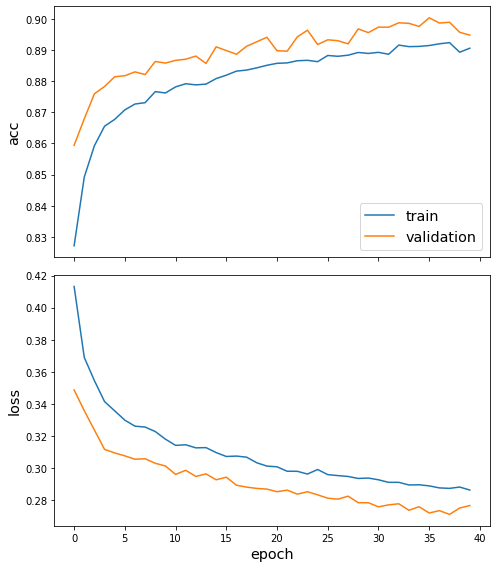

In [120]:
import stellargraph
stellargraph.utils.plot_history(history)

In [121]:
train_metrics = model.evaluate(train_flow)
val_metrics = model.evaluate(val_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nValidation Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, val_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

14310/14310 [==============================] - 569s 40ms/step - loss: 0.2729 - acc: 0.8943

Train Set Metrics of the trained model:
	loss: 0.2822
	acc: 0.8947

Validation Set Metrics of the trained model:
	loss: 0.2764
	acc: 0.8947

Test Set Metrics of the trained model:
	loss: 0.2729
	acc: 0.8943


In [122]:
print("test_matrics: ", test_metrics)

test_matrics:  [0.2729042172431946, 0.8943353891372681]


In [123]:
y_true = test_flow.targets

In [124]:
y_true

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [125]:
y_pred = model.predict(test_flow, verbose=1)

14310/14310 [==============================] - 559s 39ms/step


In [126]:
y_pred = y_pred[:, 0]

In [127]:
y_pred

array([0.27900055, 0.9495847 , 0.7495235 , ..., 0.        , 0.35329795,
       0.        ], dtype=float32)

In [128]:
data = []
for i in range(len(y_true)):
    data.append([y_true[i], y_pred[i]])

In [129]:
df = pd.DataFrame(data, columns=['y_true', 'y_pred'])

In [130]:
df.head()

,y_true,y_pred
0,1,0.279001
1,1,0.949585
2,1,0.749524
3,1,0.738770
4,1,0.999587


In [131]:
df.to_csv("raw_data.csv", index=False)

In [132]:
# AP
import numpy as np
from sklearn.metrics import average_precision_score

In [133]:
ap = average_precision_score(y_true, y_pred)

In [134]:
print("AP: ", ap)

AP:  0.9593973137496332
